In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from skimage.io import imread, imsave
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform, warp
from scipy.stats import norm 

#### wave speed:
- all for pAAA, single, triple reporter. Compare RFP wave speed in pAAA vs triple reporter
- time traveling according to size (radius, area)
- starting/ending time of the wave for the same pads
- same above but comparing repressor sequestration (IPTG, ATC)

In [2]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Positions.xlsx')
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-11-15,Ti scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-5),2023_11_15
1,2023-11-15,Tweez scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-6),2023_11_15
2,2023-11-17,Ti scope,DHL708,pLPT119&pLPT41,-,10^(-5),2023_11_17
3,2023-11-17,Tweez scope,MC4100 & DHL708,pLPT119&pLPT41,-,10^(-6),2023_11_17
4,2023-11-28,Ti scope,MC4100 & MG1655,pAAA,-,10^(-6),2023_11_28
5,2023-11-28,Tweez scope,MG1655,pAAA,-,10^(-5),2023_11_28
6,2023-11-30,Ti scope,MC4100,pAAA,-,10^(-6),2023_11_30
7,2023-11-30,Tweez scope,MC4100,pAAA,-,10^(-5),2023_11_30
8,2023-12-04,Ti scope,MC4100,pLPT107&pLPT41,IPTG,10^(-6),2023_12_04
9,2023-12-04,Tweez scope,MC4100,pLPT107&pLPT41,IPTG,10^(-5),2023_12_04


#### Process times, as they are in frames

In [3]:
df = pd.read_excel('../data_processed.xlsx')
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'exp length', 'Quality', 'colonies',
       'center_colony', 'radius_mask', 'radj_mask', 'incub_time', 'um_px',
       'vel_start', 'vel_stop', 'vel_fit_start', 'vel_fit_end',
       'time_wave_start', 'time_wave_arrival', 'degree', 'Delta used',
       'area_max_px', 'radius_px', 'area_px', 'r0', 'wave_pos_coefs',
       'wave_speed_av', 'rad_max_px', 'area_max_um', 'rad_max_um',
       'gompertz_params_um', 'gompertz_params_px', 'r0_um', 'A_gomp_um',
       'mu_gomp_um', 'l_gomp_um', 'ts_10', 'tm_um', 'A_gomp_px', 'mu_gomp_px',
       'l_gomp_px', 'time_wave_start_min', 'time_wave_arrival_min'],
      dtype='object')

In [5]:
#df['time_wave_start_min'] = df['time_wave_start'] * 10 + df['incub_time']
#df['time_wave_arrival_min'] = df['time_wave_arrival'] * 10 + df['incub_time']

In [6]:
#df.to_excel('../data_processed.xlsx', index=False)

#### Bar plots

In order to compute statistics of the start and arrival time, we have to remove the data pAAA from Ti (wave does not arrive), and 2023_12_08 Tweez (growth delayed because of aTc)

In [4]:
# Load the data
df = pd.read_excel('../data_processed.xlsx')

# Filter out the unwanted combinations
filtered_df = df[
    ~(  ((df['Date'] == '2023-11-15') & (df['Machine'] == 'Tweez scope')) | # don't get to the center
        ((df['Date'] == '2023-11-17')) | # don't get to the center
        ((df['Date'] == '2023-11-28') & (df['Machine'] == 'Ti scope')) | # don't get to the center
        ((df['Date'] == '2023-11-30') & (df['Machine'] == 'Ti scope')) | # don't get to the center
        ((df['Date'] == '2023-12-04') & (df['Machine'] == 'Ti scope') & (df['Position'].isin([22,24,26,28]))) | # don't get to the center
        ((df['Date'] == '2023-12-08') & (df['Machine'] == 'Ti scope') & (df['Chemical'] == 'ATC+')) # really slowed down because of aTc, not in Tweezers though
    )
]
filtered_df

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,A_gomp_um,mu_gomp_um,l_gomp_um,ts_10,tm_um,A_gomp_px,mu_gomp_px,l_gomp_px,time_wave_start_min,time_wave_arrival_min
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,103786.407908,343.235436,366.413055,982,477.651236,79860.270682,264.108533,366.413060,666.0,1556.0
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,148648.903676,486.687306,354.501107,1015,466.862525,114380.499530,374.490570,354.501291,616.0,1636.0
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,138470.390891,463.743309,343.273546,984,453.119680,106548.466672,356.835713,343.273661,616.0,1746.0
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,100919.606151,319.217899,320.089585,955,436.393365,77654.359914,245.627809,320.089585,816.0,1916.0
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,131433.344500,451.356518,345.419708,968,452.544838,101133.690444,347.304220,345.419723,716.0,1846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2023-12-08,Tweez scope,34,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,177118.235589,428.262230,469.682412,1345,621.827881,97184.216783,234.986172,469.682448,969.0,2279.0
156,2023-12-08,Tweez scope,35,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,192575.217112,440.124814,487.131649,1417,648.096132,105665.413243,241.495172,487.131713,979.0,2109.0
157,2023-12-08,Tweez scope,36,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,213726.858069,643.586799,363.141971,1116,485.309979,117271.253407,353.133882,363.141885,699.0,1649.0
158,2023-12-08,Tweez scope,37,MC4100,pLPT20&pLPT41,ATC+,5,10^(-5),14:18:00,19:07:00,...,192085.076368,376.098076,571.990959,1628,759.878520,105396.475610,206.363815,571.990946,969.0,2189.0


In [5]:
df = filtered_df
#df = df[df.r0_um > 0.1]
df['time_traveling'] = df['time_wave_arrival_min'] - df['time_wave_start_min']

# Group the data by Dilution and calculate the statistics
grouped_df = df.groupby(['Dilution']).agg({
    'time_wave_start_min': ['mean', 'std'],
    'time_wave_arrival_min': ['mean', 'std'],
    'wave_speed_av': ['mean', 'std'],
    'time_traveling': ['mean', 'std']
}).reset_index()

# Flatten the multi-level column index for easier access
grouped_df.columns = [
    col[0] if col[1] == '' else f'{col[0]}_{col[1]}'.strip('_')
    for col in grouped_df.columns
]

# Select only the dilutions you're interested in
selected_dilutions = grouped_df[grouped_df['Dilution'].isin(['10^(-5)', '10^(-6)'])]

In [71]:
grouped_df

,Dilution,time_wave_start_min_mean,time_wave_start_min_std,time_wave_arrival_min_mean,time_wave_arrival_min_std,wave_speed_av_mean,wave_speed_av_std,time_traveling_mean,time_traveling_std
0,10^(-5),862.981481,118.818717,1923.629630,278.594456,11.817529,3.037066,1060.648148,280.317821
1,10^(-6),1017.090909,86.076076,2350.727273,134.988215,8.689601,2.588209,1333.636364,108.099281


In [74]:
grouped_df.iloc[1,1:] / 60

time_wave_start_min_mean      16.951515
time_wave_start_min_std        1.434601
time_wave_arrival_min_mean    39.178788
time_wave_arrival_min_std      2.249804
wave_speed_av_mean             0.144827
wave_speed_av_std              0.043137
time_traveling_mean           22.227273
time_traveling_std             1.801655
Name: 1, dtype: object

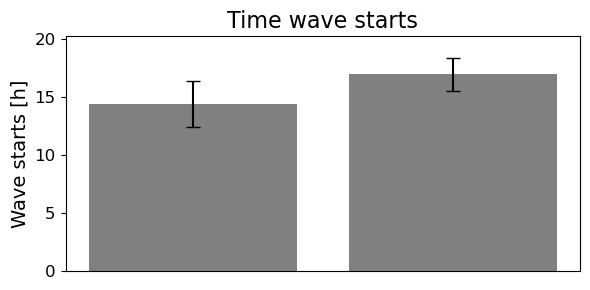

In [77]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6, 3))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))

# Calculate the maximum y-axis limit
max_tm = grouped_df['time_wave_start_min_mean']/60 + grouped_df['time_wave_start_min_std']/60
global_max = max_tm.max()

# Plot the data
for pos, row in grouped_df.iterrows():
    ax.bar(pos, row['time_wave_start_min_mean']/60, yerr=row['time_wave_start_min_std']/60, capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{int(row["sum"])}', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set the title and labels
ax.set_title('Time wave starts', fontsize=16)
#ax.set_xlabel('Dilution', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Wave starts [h]', fontsize=14)
#ax.set_xticks([0,1])
ax.set_xticks([])
#ax.set_xticklabels(['10^(-5)','10^(-6)'], fontsize=14)
ax.set_xticklabels([], fontsize=14)
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('tstart_dil.png', dpi=300)
# Show the plot
plt.show()

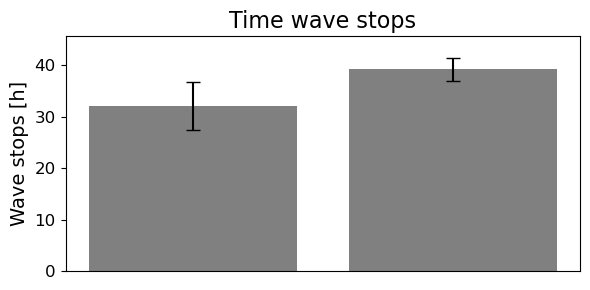

In [78]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6, 3))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))

# Calculate the maximum y-axis limit
max_tm = grouped_df['time_wave_arrival_min_mean']/60 + grouped_df['time_wave_arrival_min_std']/60
global_max = max_tm.max()

# Plot the data
for pos, row in grouped_df.iterrows():
    ax.bar(pos, row['time_wave_arrival_min_mean']/60, yerr=row['time_wave_arrival_min_std']/60, capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{int(row["sum"])}', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set the title and labels
ax.set_title('Time wave stops', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Wave stops [h]', fontsize=14)
ax.set_xticks([])
ax.set_xticklabels([], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('tstop_dil.png', dpi=300)
# Show the plot
plt.show()

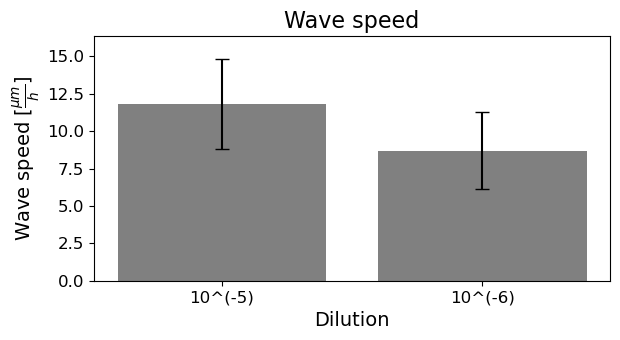

In [90]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6.3, 3.5))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))

# Calculate the maximum y-axis limit
max_tm = grouped_df['wave_speed_av_mean'] + grouped_df['wave_speed_av_std']
global_max = max_tm.max()

# Plot the data
for pos, row in grouped_df.iterrows():
    ax.bar(pos, row['wave_speed_av_mean'], yerr=row['wave_speed_av_std'], capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{int(row["sum"])}', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set the title and labels
ax.set_title('Wave speed', fontsize=16)
#ax.set_xlabel('', fontsize=14)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
ax.set_xticks([0,1])
#ax.set_xticks([])
ax.set_xticklabels(['10^(-5)','10^(-6)'], fontsize=14)
#ax.set_xticklabels([], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('ws_dil.png', dpi=300)
# Show the plot
plt.show()

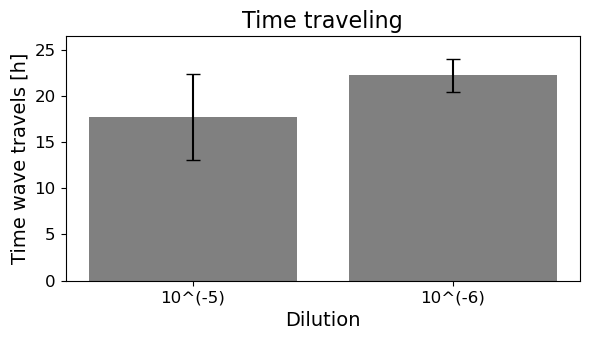

In [89]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6, 3.5))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_df)))

# Calculate the maximum y-axis limit
max_tm = grouped_df['time_traveling_mean']/60 + grouped_df['time_traveling_std']/60
global_max = max_tm.max()

# Plot the data
for pos, row in grouped_df.iterrows():
    ax.bar(pos, row['time_traveling_mean']/60, yerr=row['time_traveling_std']/60, capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{int(row["sum"])}', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set the title and labels
ax.set_title('Time traveling', fontsize=16)
#ax.set_xlabel('', fontsize=14)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel('Time wave travels [h]', fontsize=14)
#ax.set_xticks([])
ax.set_xticks([0,1])
#ax.set_xticklabels([], rotation=45, ha="right")
ax.set_xticklabels(['10^(-5)','10^(-6)'], fontsize=14)
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('ttravel_dil.png', dpi=300)
# Show the plot
plt.show()

#### Per Number of colonies N

In [12]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
positions = pd.read_excel('../Positions.xlsx')

df = pd.read_excel('../data_processed.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')

# Filter out the unwanted combinations
filtered_df = df[
    ~(  ((df['Date'] == '2023-11-15') & (df['Machine'] == 'Tweez scope')) | # don't get to the center
        ((df['Date'] == '2023-11-17')) | # don't get to the center
        ((df['Date'] == '2023-11-28') & (df['Machine'] == 'Ti scope')) | # don't get to the center
        ((df['Date'] == '2023-11-30') & (df['Machine'] == 'Ti scope')) | # don't get to the center
        ((df['Date'] == '2023-12-04') & (df['Machine'] == 'Ti scope') & (df['Position'].isin([22,24,26,28]))) | # don't get to the center
        ((df['Date'] == '2023-12-08') & (df['Machine'] == 'Ti scope') & (df['Chemical'] == 'ATC+')) # really slowed down because of aTc, not in Tweezers though
    )
]
filtered_df

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,A_gomp_um,mu_gomp_um,l_gomp_um,ts_10,tm_um,A_gomp_px,mu_gomp_px,l_gomp_px,time_wave_start_min,time_wave_arrival_min
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,103786.407908,343.235436,366.413055,982,477.651236,79860.270682,264.108533,366.413060,666.0,1556.0
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,148648.903676,486.687306,354.501107,1015,466.862525,114380.499530,374.490570,354.501291,616.0,1636.0
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,138470.390891,463.743309,343.273546,984,453.119680,106548.466672,356.835713,343.273661,616.0,1746.0
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,100919.606151,319.217899,320.089585,955,436.393365,77654.359914,245.627809,320.089585,816.0,1916.0
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,131433.344500,451.356518,345.419708,968,452.544838,101133.690444,347.304220,345.419723,716.0,1846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2023-12-08,Tweez scope,34,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,177118.235589,428.262230,469.682412,1345,621.827881,97184.216783,234.986172,469.682448,969.0,2279.0
156,2023-12-08,Tweez scope,35,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,192575.217112,440.124814,487.131649,1417,648.096132,105665.413243,241.495172,487.131713,979.0,2109.0
157,2023-12-08,Tweez scope,36,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,213726.858069,643.586799,363.141971,1116,485.309979,117271.253407,353.133882,363.141885,699.0,1649.0
158,2023-12-08,Tweez scope,37,MC4100,pLPT20&pLPT41,ATC+,5,10^(-5),14:18:00,19:07:00,...,192085.076368,376.098076,571.990959,1628,759.878520,105396.475610,206.363815,571.990946,969.0,2189.0


In [13]:
df = filtered_df

In [14]:
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'exp length', 'Quality', 'colonies',
       'center_colony', 'radius_mask', 'radj_mask', 'incub_time', 'um_px',
       'vel_start', 'vel_stop', 'vel_fit_start', 'vel_fit_end',
       'time_wave_start', 'time_wave_arrival', 'degree', 'Delta used',
       'area_max_px', 'radius_px', 'area_px', 'r0', 'wave_pos_coefs',
       'wave_speed_av', 'rad_max_px', 'area_max_um', 'rad_max_um',
       'gompertz_params_um', 'gompertz_params_px', 'r0_um', 'A_gomp_um',
       'mu_gomp_um', 'l_gomp_um', 'ts_10', 'tm_um', 'A_gomp_px', 'mu_gomp_px',
       'l_gomp_px', 'time_wave_start_min', 'time_wave_arrival_min'],
      dtype='object')

In [15]:
pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Merge the grouped data back into the original DataFrame
df_N_A_gomp_all_pos = df.merge(pos_grouped, on=['Date', 'Machine', 'Pad'], how='left')

# Display the updated DataFrame
df_N_A_gomp_all_pos

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,mu_gomp_um,l_gomp_um,ts_10,tm_um,A_gomp_px,mu_gomp_px,l_gomp_px,time_wave_start_min,time_wave_arrival_min,total_colonies
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,343.235436,366.413055,982,477.651236,79860.270682,264.108533,366.413060,666.0,1556.0,19.0
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,486.687306,354.501107,1015,466.862525,114380.499530,374.490570,354.501291,616.0,1636.0,19.0
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,463.743309,343.273546,984,453.119680,106548.466672,356.835713,343.273661,616.0,1746.0,19.0
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,319.217899,320.089585,955,436.393365,77654.359914,245.627809,320.089585,816.0,1916.0,19.0
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,451.356518,345.419708,968,452.544838,101133.690444,347.304220,345.419723,716.0,1846.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-12-08,Tweez scope,34,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,428.262230,469.682412,1345,621.827881,97184.216783,234.986172,469.682448,969.0,2279.0,4.0
117,2023-12-08,Tweez scope,35,MC4100,pLPT20&pLPT41,ATC+,7,10^(-5),14:18:00,19:07:00,...,440.124814,487.131649,1417,648.096132,105665.413243,241.495172,487.131713,979.0,2109.0,4.0
118,2023-12-08,Tweez scope,36,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,643.586799,363.141971,1116,485.309979,117271.253407,353.133882,363.141885,699.0,1649.0,12.0
119,2023-12-08,Tweez scope,37,MC4100,pLPT20&pLPT41,ATC+,5,10^(-5),14:18:00,19:07:00,...,376.098076,571.990959,1628,759.878520,105396.475610,206.363815,571.990946,969.0,2189.0,15.0


#### Vs N

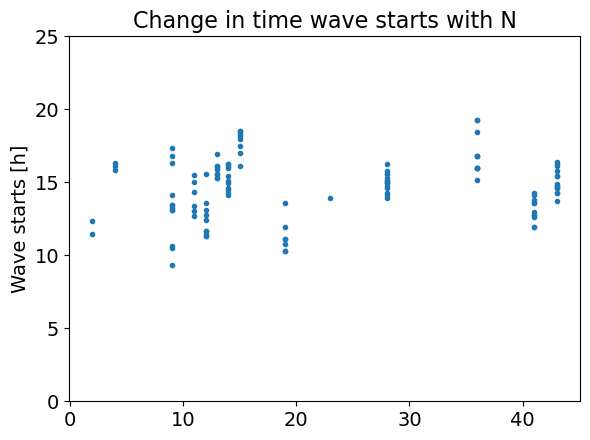

In [91]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['time_wave_start_min']/60,'.')
#plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel('Wave starts [h]', fontsize=14)
plt.ylim([0,25])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave starts with N', fontsize=16)
plt.tight_layout()
plt.savefig('wstart_N.png', dpi=300)
plt.show()

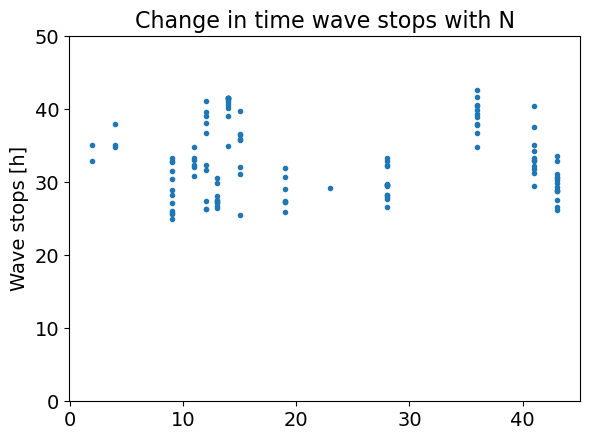

In [92]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['time_wave_arrival_min']/60,'.')
#plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel('Wave stops [h]', fontsize=14)
plt.ylim([0,50])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave stops with N', fontsize=16)
plt.tight_layout()
plt.savefig('wstop_N.png', dpi=300)
plt.show()

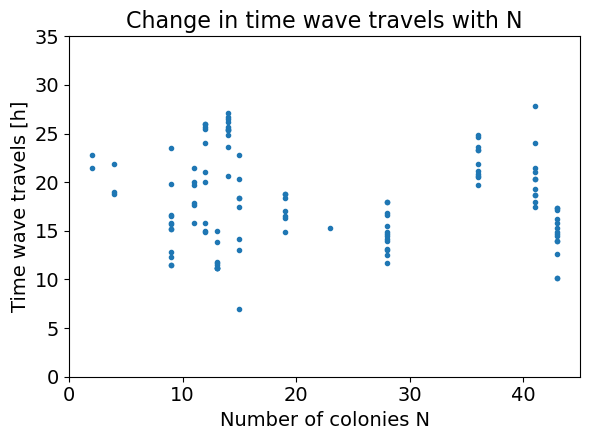

In [95]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['total_colonies'],(df_N_A_gomp_all_pos['time_wave_arrival_min'] - df_N_A_gomp_all_pos['time_wave_start_min']) / 60,'.')
plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel('Time wave travels [h]', fontsize=14)
plt.xlim([0,45])
plt.ylim([0,35])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave travels with N', fontsize=16)
plt.tight_layout()
plt.savefig('wtravel_N.png', dpi=300)
plt.show()

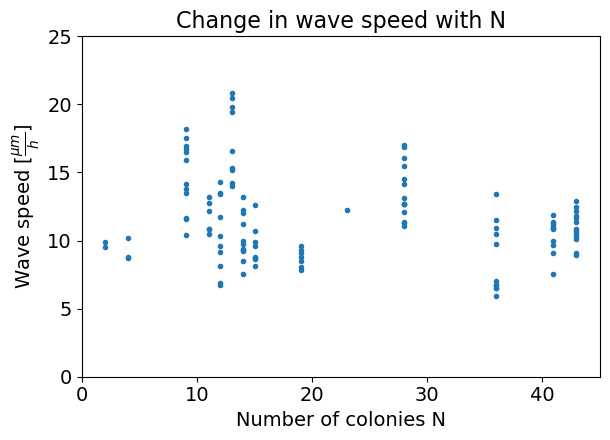

In [126]:
plt.figure(figsize=(6.2,4.5))
plt.plot(df_N_A_gomp_all_pos['total_colonies'],df_N_A_gomp_all_pos['wave_speed_av'],'.')
plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
plt.ylim([0,25])

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Change in wave speed with N', fontsize=16)
plt.tight_layout()
plt.savefig('ws_N.png', dpi=300)
plt.show()

#### All Vs A Gompertz

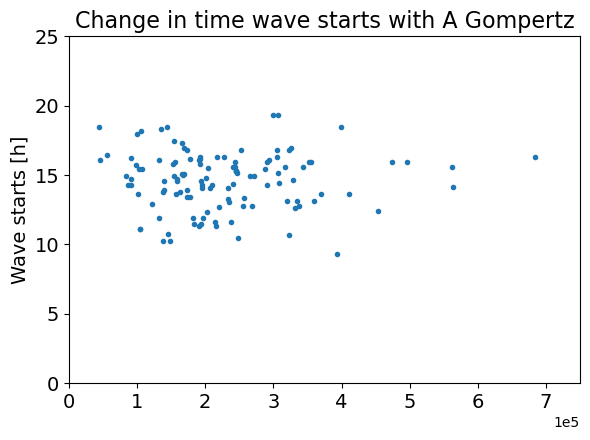

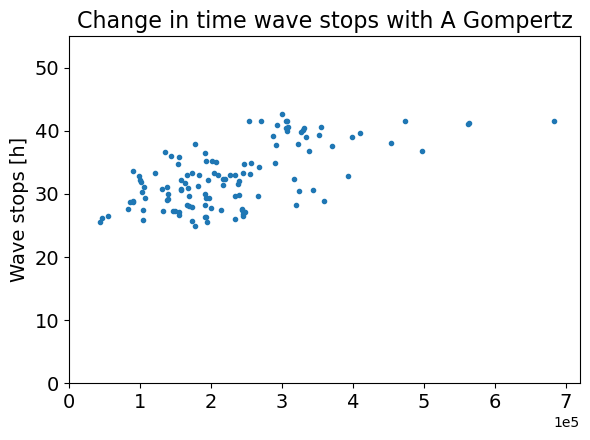

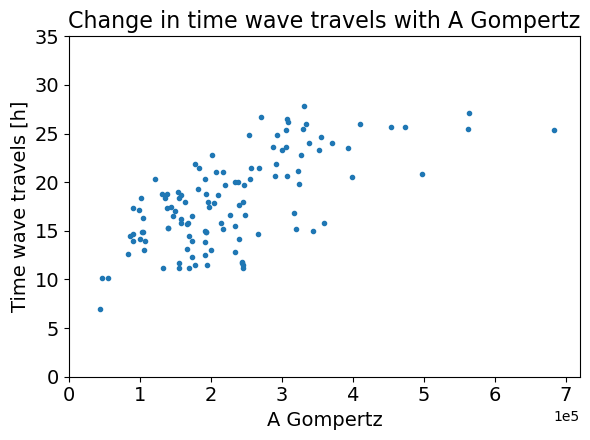

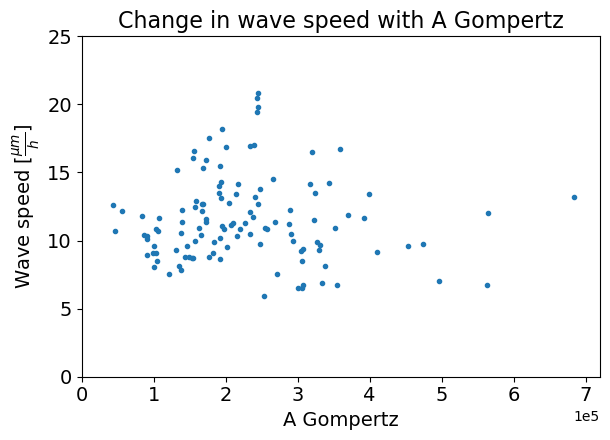

In [128]:
## time starts
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['A_gomp_um'],df_N_A_gomp_all_pos['time_wave_start_min'] / 60,'.')
#plt.xlabel('A Gompertz', fontsize=14)
plt.ylabel('Wave starts [h]', fontsize=14)
plt.xlim([0,750000])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave starts with A Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstart_AGomp.png', dpi=300)
plt.show()


## time arrival
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['A_gomp_um'],df_N_A_gomp_all_pos['time_wave_arrival_min'] / 60,'.')
#plt.xlabel('A Gompertz', fontsize=14)
plt.ylabel('Wave stops [h]', fontsize=14)
plt.xlim([0,720000])
plt.ylim([0,55])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave stops with A Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstop_AGomp.png', dpi=300)
plt.show()


## time wave travels
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['A_gomp_um'],(df_N_A_gomp_all_pos['time_wave_arrival_min'] - df_N_A_gomp_all_pos['time_wave_start_min']) / 60,'.')
plt.xlabel('A Gompertz', fontsize=14)
plt.ylabel('Time wave travels [h]', fontsize=14)
plt.xlim([0,720000])
plt.ylim([0,35])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave travels with A Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wtravel_AGomp.png', dpi=300)
plt.show()


## wave speed
plt.figure(figsize=(6.2,4.5))
plt.plot(df_N_A_gomp_all_pos['A_gomp_um'],df_N_A_gomp_all_pos['wave_speed_av'] ,'.')
plt.xlabel('A Gompertz', fontsize=14)
plt.ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
plt.xlim([0,720000])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in wave speed with A Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('ws_AGomp.png', dpi=300)
plt.show()

#### All Vs l Gompertz

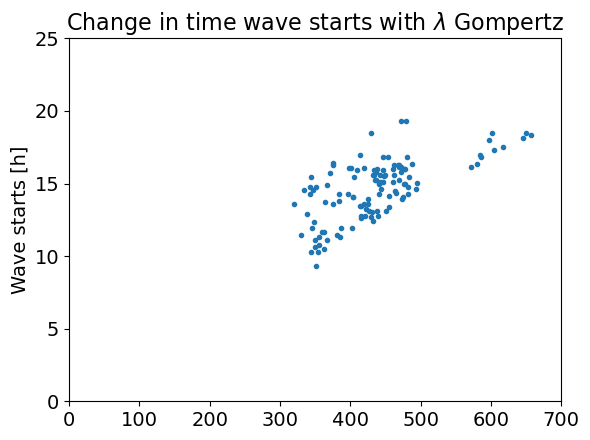

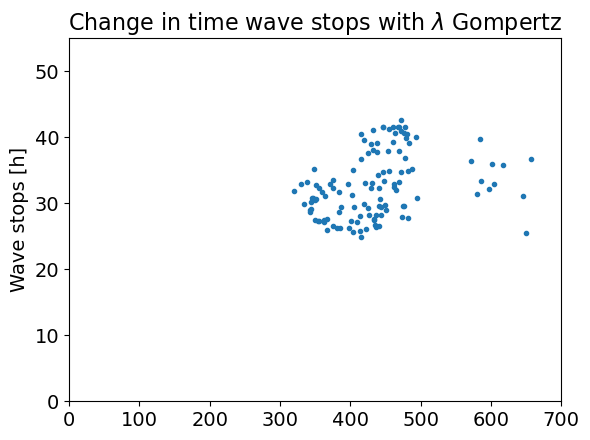

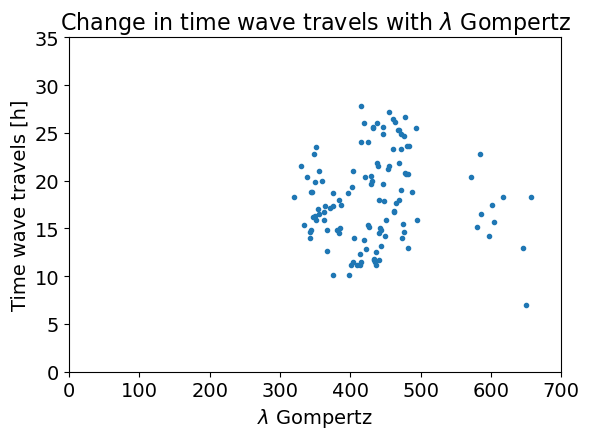

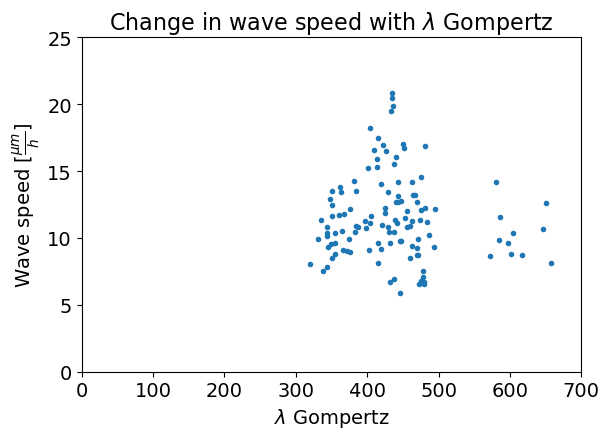

In [133]:
## time starts
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['l_gomp_um'],df_N_A_gomp_all_pos['time_wave_start_min'] / 60,'.')
#plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel('Wave starts [h]', fontsize=14)
plt.xlim([0,700])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave starts with $\lambda$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstart_lGomp.png', dpi=300)
plt.show()


## time arrival
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['l_gomp_um'],df_N_A_gomp_all_pos['time_wave_arrival_min'] / 60,'.')
#plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel('Wave stops [h]', fontsize=14)
plt.xlim([0,700])
plt.ylim([0,55])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave stops with $\lambda$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstop_lGomp.png', dpi=300)
plt.show()


## time wave travels
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['l_gomp_um'],(df_N_A_gomp_all_pos['time_wave_arrival_min'] - df_N_A_gomp_all_pos['time_wave_start_min']) / 60,'.')
plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel('Time wave travels [h]', fontsize=14)
plt.xlim([0,700])
plt.ylim([0,35])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave travels with $\lambda$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wtravel_lGomp.png', dpi=300)
plt.show()


## wave speed
plt.figure(figsize=(6.2,4.5))
plt.plot(df_N_A_gomp_all_pos['l_gomp_um'],df_N_A_gomp_all_pos['wave_speed_av'] ,'.')
plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
plt.xlim([0,700])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in wave speed with $\lambda$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('ws_lGomp.png', dpi=300)
plt.show()

#### All vs muGomp

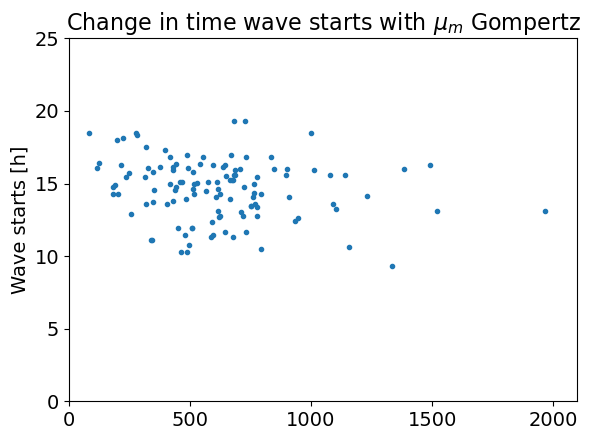

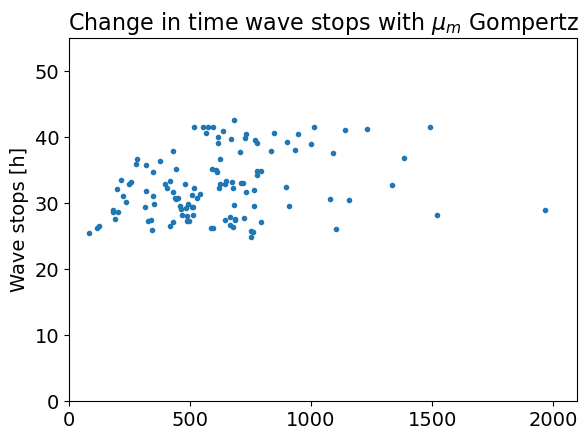

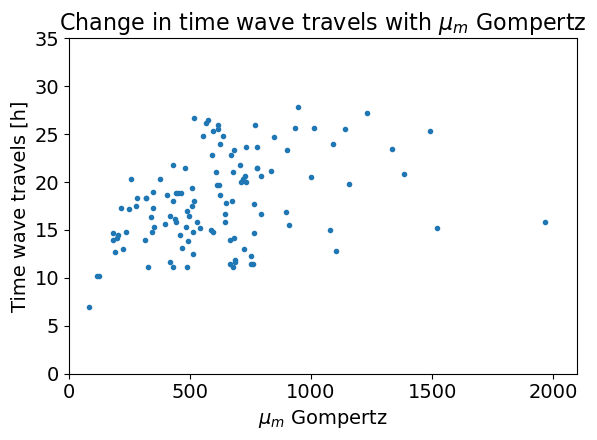

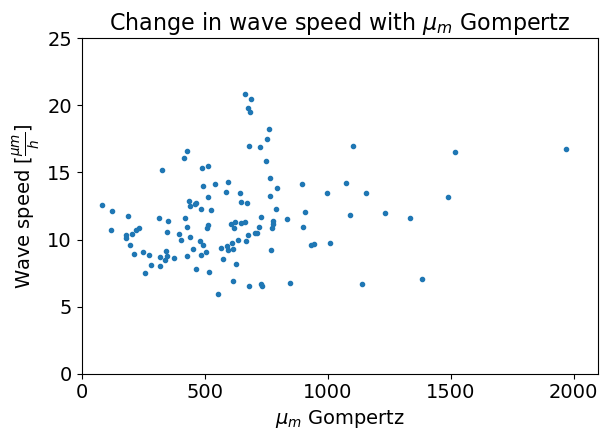

In [140]:
## time starts
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['mu_gomp_um'],df_N_A_gomp_all_pos['time_wave_start_min'] / 60,'.')
#plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel('Wave starts [h]', fontsize=14)
plt.xlim([0,2100])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave starts with $\mu_m$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstart_muGomp.png', dpi=300)
plt.show()


## time arrival
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['mu_gomp_um'],df_N_A_gomp_all_pos['time_wave_arrival_min'] / 60,'.')
#plt.xlabel('$\lambda$ Gompertz', fontsize=14)
plt.ylabel('Wave stops [h]', fontsize=14)
plt.xlim([0,2100])
plt.ylim([0,55])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave stops with $\mu_m$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wstop_muGomp.png', dpi=300)
plt.show()


## time wave travels
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos['mu_gomp_um'],(df_N_A_gomp_all_pos['time_wave_arrival_min'] - df_N_A_gomp_all_pos['time_wave_start_min']) / 60,'.')
plt.xlabel('$\mu_m$ Gompertz', fontsize=14)
plt.ylabel('Time wave travels [h]', fontsize=14)
plt.xlim([0,2100])
plt.ylim([0,35])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in time wave travels with $\mu_m$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('wtravel_muGomp.png', dpi=300)
plt.show()


## wave speed
plt.figure(figsize=(6.2,4.5))
plt.plot(df_N_A_gomp_all_pos['mu_gomp_um'],df_N_A_gomp_all_pos['wave_speed_av'] ,'.')
plt.xlabel('$\mu_m$ Gompertz', fontsize=14)
plt.ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
plt.xlim([0,2100])
plt.ylim([0,25])
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
plt.title('Change in wave speed with $\mu_m$ Gompertz', fontsize=16)
plt.tight_layout()
plt.savefig('ws_muGomp.png', dpi=300)
plt.show()

#### All Vs $r_0$ 

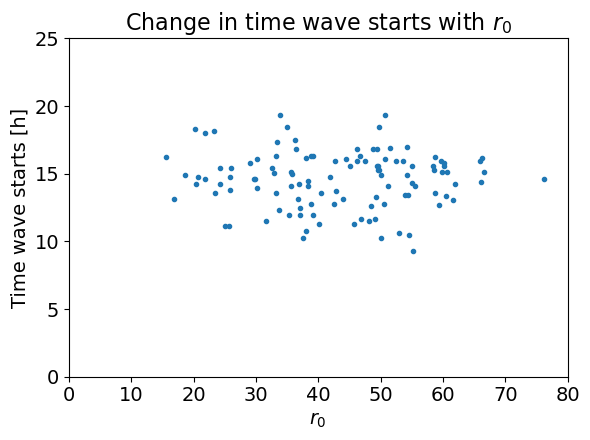

In [115]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['r0_um'],df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['time_wave_start_min']/60,'.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel('Time wave starts [h]', fontsize=14)
plt.xlim([0,80])
plt.ylim([0,25])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave starts with $r_0$', fontsize=16)
plt.tight_layout()
plt.savefig('tstart_r0.png', dpi=300)
plt.show()

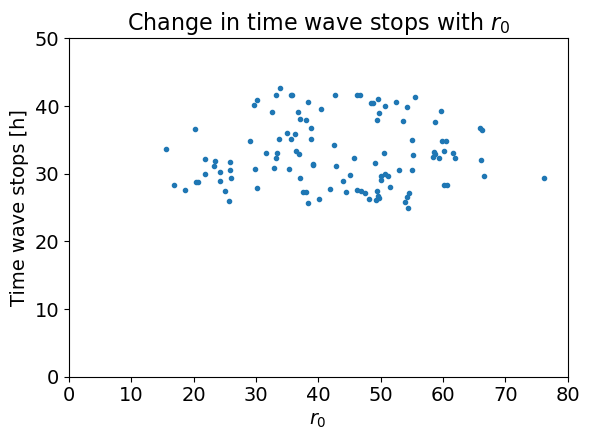

In [116]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['r0_um'],df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['time_wave_arrival_min']/60,'.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel('Time wave stops [h]', fontsize=14)
plt.xlim([0,80])
plt.ylim([0,50])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave stops with $r_0$', fontsize=16)
plt.tight_layout()
plt.savefig('tstop_r0.png', dpi=300)
plt.show()

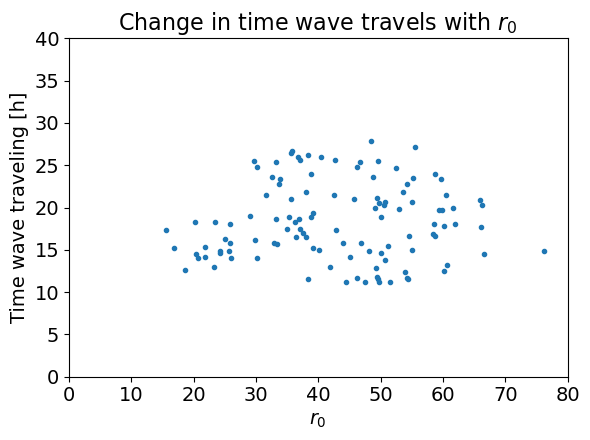

In [118]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['r0_um'],df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['time_wave_arrival_min']/60-df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['time_wave_start_min']/60,'.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel('Time wave traveling [h]', fontsize=14)
plt.xlim([0,80])
plt.ylim([0,40])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in time wave travels with $r_0$', fontsize=16)
plt.tight_layout()
plt.savefig('ttravel_r0.png', dpi=300)
plt.show()

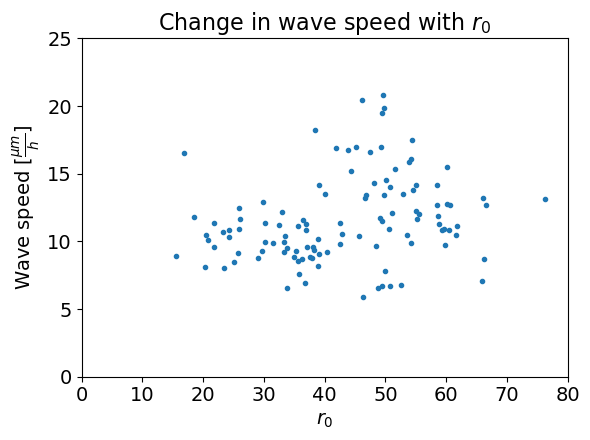

In [97]:
plt.figure(figsize=(6,4.5))
plt.plot(df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['r0_um'],df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 0.1]['wave_speed_av'],'.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel(r'Wave speed [$\frac{\mu m}{h}$]', fontsize=14)
plt.xlim([0,80])
plt.ylim([0,25])

# Adjust ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))

plt.title('Change in wave speed with $r_0$', fontsize=16)
plt.tight_layout()
plt.savefig('ws_r0.png', dpi=300)
plt.show()